In [114]:
%reload_ext autoreload
%autoreload 2

# Imports

In [115]:
from kret_notebook import *  # NOTE import first
from kret_matplotlib.mpl_nb_imports import *
from kret_np_pd.np_pd_nb_imports import *
from kret_polars.polars_nb_imports import *
from kret_rosetta.rosetta_nb_imports import *
from kret_lgbm.lgbm_nb_imports import *
from kret_sklearn.sklearn_nb_imports import *
from kret_torch_utils.torch_nb_imports import *
from kret_lightning.lightning_nb_imports import *
from kret_tqdm.tqdm_nb_imports import *
from kret_type_hints.types_nb_imports import *
from kret_utils.utils_nb_imports import *

# from kret_wandb.wandb_nb_imports import *  # NOTE this is slow to import

# Load Data

In [116]:
df_load = FunctionTransformer(
    func=pd.read_csv, validate=False, kw_args={"filepath_or_buffer": UKS_CONSTANTS.DATA_DIR / "medical_cost.csv"}
)

## Cleanup

In [117]:
df_load = FunctionTransformer(func=pd.read_csv, validate=False)
custom_cleanup = FunctionTransformer(func=UKS_NP_PD.data_cleanup, validate=False, kw_args={"ret": True})

In [118]:
pipeline_load_and_clean = PipelinePD(
    steps=[
        ("df_load", df_load),
        ("cleanup_custom", custom_cleanup),
    ]
)

In [119]:
df = pipeline_load_and_clean.fit_transform_df(UKS_CONSTANTS.DATA_DIR / "medical_cost.csv")

In [ ]:
features, target = UKS_NP_PD.pop_label_and_drop(df, label_col="charges", drop_cols=["Id"])

In [121]:
x_train, x_val, y_train, y_val = train_test_split(features, target, test_size=0.15, random_state=0)

In [122]:
dtt([target, y_train, y_val])

,0
,float64
203,37133.898
381,42303.692
631,1977.815
800,7046.722
1146,52590.829
,0
,float64
172,36219.405
323,3645.089


## Scaler & OLS

In [123]:
float_cols = ["age", "bmi", "children"]
cat_cols = ["sex", "region"]

In [124]:
regressor = RegressionResidualAdder("ElasticNet", {"alpha": 0.1, "l1_ratio": 0.5})

In [125]:
power_transformer = PowerTransformer(method="yeo-johnson", standardize=True)
one_hot = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

column_transform = ColumnTransformer(
    transformers=[("scaler", power_transformer, float_cols), ("onehot", one_hot, cat_cols)],
    remainder="passthrough",
    verbose_feature_names_out=False,
    verbose=True,
)

In [126]:
steps = [("column_transform", column_transform), ("ols", regressor)]

In [127]:
pipeline_scale_ols = PipelinePD(steps=steps)

In [128]:
x_train = pipeline_scale_ols.fit_transform_df(x_train, y_train)
x_val = pipeline_scale_ols.transform_df(x_val)

[ColumnTransformer] ........ (1 of 3) Processing scaler, total=   0.0s
[ColumnTransformer] ........ (2 of 3) Processing onehot, total=   0.0s
[ColumnTransformer] ..... (3 of 3) Processing remainder, total=   0.0s


In [129]:
dtt([x_train, x_val], n=2)

,age,bmi,children,sex_female,sex_male,region_northeast,region_northwest,region_southeast,region_southwest,smoker,y_hat
,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64
1183,0.667,-0.499,0.308,1.000,0.000,1.000,0.000,0.000,0.000,False,11350.470
125,-0.911,-0.256,-1.072,1.000,0.000,1.000,0.000,0.000,0.000,False,5882.809
,age,bmi,children,sex_female,sex_male,region_northeast,region_northwest,region_southeast,region_southwest,smoker,y_hat
,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64
31,-1.605,-0.682,-1.072,1.000,0.000,1.000,0.000,0.000,0.000,False,2806.867
303,-0.751,0.425,0.961,1.000,0.000,0.000,0.000,1.000,0.000,False,8280.783


In [130]:
y_hat_train_ols = x_train.pop("y_hat")
resid_train = y_train - y_hat_train_ols
y_hat_val_ols = x_val.pop("y_hat")
resid_val = y_val - y_hat_val_ols

In [131]:
dtt([x_train, x_val, resid_train, resid_val], n=2)

age 
 bmi 
 children 
 sex_female 
 sex_male 
 region_northeast 
 region_northwest 
 region_southeast 
 region_southwest 
 smoker 
 
 
 
 float64 
 float64 
 float64 
 float64 
 float64 
 float64 
 float64 
 float64 
 float64 
 bool 
 
 
 
 
 1199 
 -0.518 
 -0.774 
 0.961 
 1.000 
 0.000 
 0.000 
 0.000 
 0.000 
 1.000 
 False 
 
 
 581 
 -1.512 
 0.042 
 -1.072 
 0.000 
 1.000 
 0.000 
 1.000 
 0.000 
 0.000 
 False 
 
 
 
 
 
 
 age 
 bmi 
 children 
 sex_female 
 sex_male 
 region_northeast 
 region_northwest 
 region_southeast 
 region_southwest 
 smoker 
 
 
 
 float64 
 float64 
 float64 
 float64 
 float64 
 float64 
 float64 
 float64 
 float64 
 bool 
 
 
 
 
 1195 
 -1.512 
 -0.401 
 1.367 
 1.000 
 0.000 
 0.000 
 1.000 
 0.000 
 0.000 
 False 
 
 
 717 
 1.408 
 -1.043 
 0.308 
 0.000 
 1.000 
 0.000 
 1.000 
 0.000 
 0.000 
 False 
 
 
 
 
 
 
 y_hat 
 
 
 
 float64 
 
 
 
 
 1199 
 -1367.479 
 
 
 581 
 -2522.577 
 
 
 
 
 
 
 y_hat 
 
 
 
 float64 
 
 
 
 
 1195 
 14342.133 
 
 
 717 
 696.381

## Train Model

In [132]:
raise ValueError("Stop")

ValueError: Stop

In [133]:
LGBM_Defaults.LGBM_REGRESSOR_DEFAULTS

{'boosting_type': 'gbdt',
 'objective': 'regression',
 'num_leaves': 31,
 'max_depth': 7,
 'learning_rate': 0.1,
 'reg_alpha': 0.001,
 'reg_lambda': 0.001,
 'n_jobs': -2,
 'bagging_fraction': 0.85,
 'feature_fraction': 0.85,
 'min_data_in_leaf': 20}

In [134]:
model = LGBMRegressor(**LGBM_Defaults.LGBM_REGRESSOR_DEFAULTS)

In [135]:
fit_defaults = LGBM_Defaults.LGBM_FIT_DEFAULTS
fit_defaults

{'eval_metric': 'l2',
 'callbacks': [<lightgbm.callback._EarlyStoppingCallback at 0x108f1f830>,
  <lightgbm.callback._RecordEvaluationCallback at 0x164c16f00>]}

In [136]:
model.fit(x_train, resid_train, eval_set=[(x_val, resid_val)], **LGBM_Defaults.LGBM_FIT_DEFAULTS)

[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 324
[LightGBM] [Info] Number of data points in the train set: 1137, number 

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,7
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,'regression'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [137]:
LGBM_Defaults.EVAL_RECORDS

{'valid_0': OrderedDict([('l2',
               [np.float64(38385174.47993032),
                np.float64(37098929.129704185),
                np.float64(33474314.3326015),
                np.float64(33370931.997293644),
                np.float64(30628908.47969484),
                np.float64(28203473.156495314),
                np.float64(26285766.533003997),
                np.float64(24746424.69903889),
                np.float64(23478187.218927268),
                np.float64(22466177.041271295),
                np.float64(21615072.75731729),
                np.float64(20931758.77288189),
                np.float64(20435617.25496578),
                np.float64(20409593.353689417),
                np.float64(19886705.06795848),
                np.float64(19915498.302903794),
                np.float64(19760089.02855164),
                np.float64(19730119.003629327),
                np.float64(19342492.67247273),
                np.float64(18998144.803172894),
                np.

In [138]:
# model = lgb.train(
#     params=LGBM_Defaults.LGBM_REGRESSOR_DEFAULTS,  # type:ignore[arg-type]
#     train_set=train_data,
#     valid_sets=[test_data],
#     num_boost_round=1000,
#     callbacks=[early_stopping(stopping_rounds=50), log_evaluation(period=100)],
# )

# NOTE ^ bad performance

In [139]:
y_pred_resid = model.predict(x_val)
y_hat = y_pred_resid + y_hat_val_ols

[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


# Sandbox

In [140]:
gs = GroupScatterUKS(y_val, y_hat)

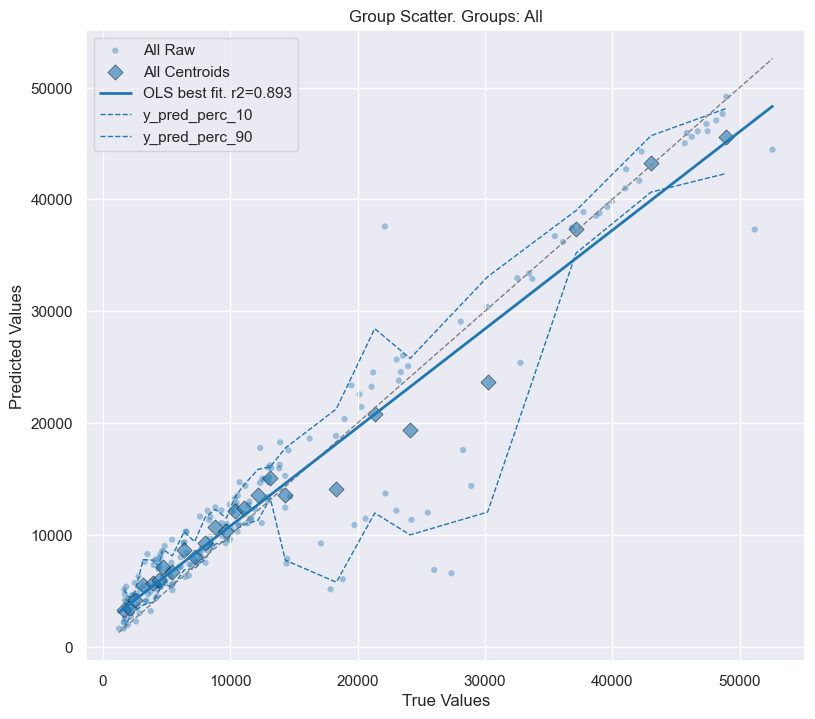

In [141]:
gs.plot(scatters=("raw", "centroids"), percentiles=(10, 90))

In [142]:
gs_resid = GroupScatterUKS(resid_val, y_pred_resid)

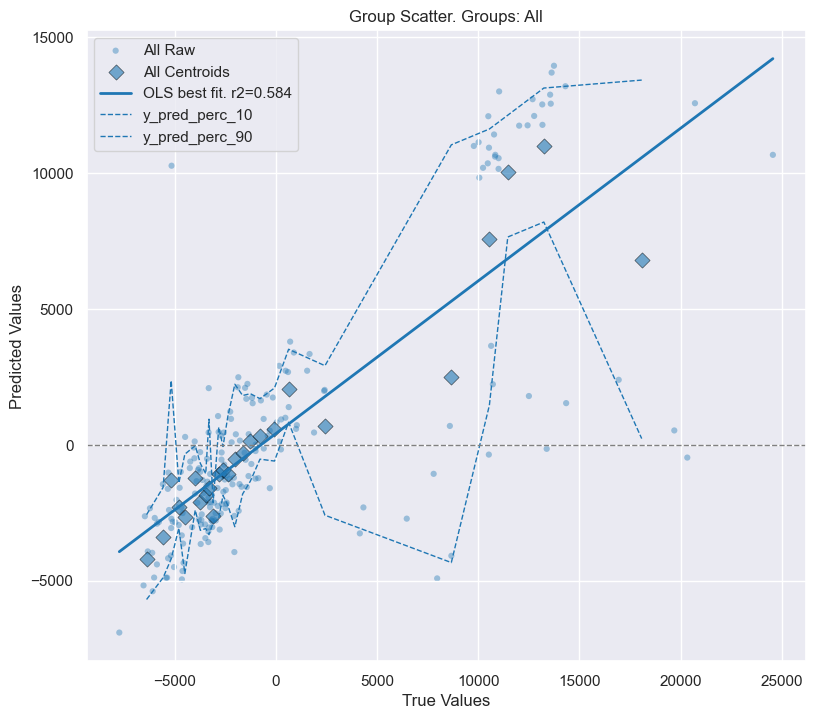

In [143]:
gs_resid.plot(scatters=("raw", "centroids"), percentiles=(10, 90), addtl_plots="y_0")

In [144]:
gs_ols = GroupScatterUKS(y_val, y_hat_val_ols)

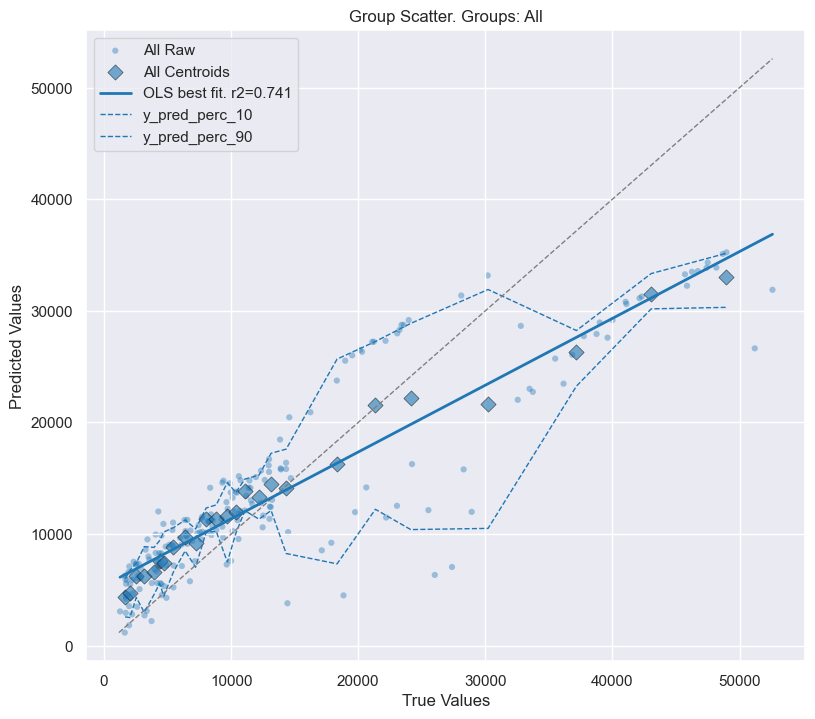

In [145]:
gs_ols.plot(scatters=("raw", "centroids"), percentiles=(10, 90), addtl_plots="identity")

# Save & Load

In [146]:
raise ValueError("Stop before save")

ValueError: Stop before save

## Save

In [ ]:
model_filename = "lgbm-medical-example.pkl"
load_and_clean = "load_and_clean.pkl"
scale_and_predict = "scale_and_predict.pkl"
save_folder = UKS_CONSTANTS.LGBM_MODEL_WEIGHT_DIR / "medical"
# os.mkdir(save_folder, exist_ok=True)

In [ ]:
joblib.dump(model, save_folder / model_filename)
joblib.dump(pipeline_load_and_clean, save_folder / load_and_clean)
joblib.dump(pipeline_scale_ols, save_folder / scale_and_predict)

['/Users/Akseldkw/coding/data_kretsinger/lgbm/medical/scale_and_predict.pkl']

## Load

In [ ]:
model_loaded: LGBMRegressor = joblib.load(UKS_CONSTANTS.LGBM_MODEL_WEIGHT_DIR / model_filename)

In [ ]:
model_loaded

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,7
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,'regression'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [ ]:
y_pred_resid_loaded = model_loaded.predict(x_val)
y_hat_loaded = y_pred_resid_loaded + y_hat_val_ols

[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


In [ ]:
gs_loaded = GroupScatterUKS(y_val, y_hat_loaded)

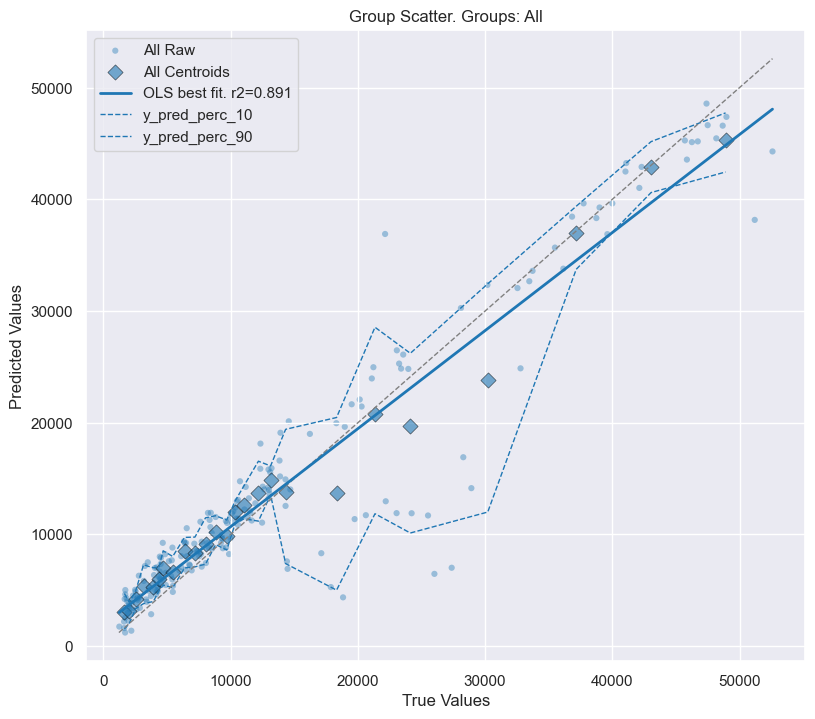

In [ ]:
gs.plot(scatters=("raw", "centroids"), percentiles=(10, 90))